# MEC Entry: Introduction to image registration with VoxelMorph
Adrian Dalca and Andrew Hoopes    

This tutorial covers unsupervised learning-based registration, using the [VoxelMorph](https://github.com/voxelmorph/voxelmorph) framework.

### Outline
- **Core concepts with MNIST**   
We will first learn to deal with data, building a model, training, registration and generalization
- **More realistic complexity: Brain MRI (2D slices)**  
We will then show how these models work for 2d slices of brain scans, presenting a more complex scenario    
- **Realistic 3D Brain MRI**  
We will illustrate full 3D registration
- **Bonus: Building Templates (Atlases)**

This tutorial is focused on tensorflow, but pytorch code covering most utilities is available as well.

Throughout this tutorial we assume that the images have been rigidly aligned in a (roughly) similar space.  
Rigid alignment is also possible with VoxelMorph, but it's not our focus here.  

---

# Preamble

## Setup of environment

In [1]:
# unfortunately, google colab recently switched to default tensorflow 2.5.0,
# which gives peculiar errors at times.
# We'll go back to 2.4.1 for this tutorial.

# This should take a few seconds. If for some reason this fails, feel free to ignore this cell
# and move on. Most cells should work fine.
!pip uninstall tensorflow -y
!pip install tensorflow==2.4.1

ERROR: Could not find a version that satisfies the requirement tensorflow==2.4.1 (from versions: 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0)
ERROR: No matching distribution found for tensorflow==2.4.1
You should consider upgrading via the 'C:\Users\abdal\Documents\Master\EMJMD MAIA\SEMESTER 3 - UdG\MIRA\code\env\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
# install voxelmorph, which will also install dependencies: neurite and pystrum
!pip install voxelmorph

You should consider upgrading via the 'C:\Users\abdal\Documents\Master\EMJMD MAIA\SEMESTER 3 - UdG\MIRA\code\env\Scripts\python.exe -m pip install --upgrade pip' command.


We'll start with some common imports  

In [3]:
# imports
import os, sys

# third party imports
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

Next, we import two packages that will help us   
- [voxelmorph](http://voxelmorph.mit.edu) is a deep-learning based registration library  
- [neurite](https://github.com/adalca/neurite) is a library for medical image analysis with tensorflow  

In [4]:
# local imports
import voxelmorph as vxm
import neurite as ne

---

## Data

We're going to start by registering 2D MNIST digits, and then move on to medical data later. If the data is small (like 2D MNIST), you can often load it in memory, which enables for faster training and testing. If the data is large (large 3D scans), we will likely need to load the scans on demand. More on this later.

First, we're going to **load the data**. Luckily, MNIST comes with the keras framework, so we can just load it here



In [5]:
# You should most often have this import together with all other imports at the top,
# but we include here here explicitly to show where data comes from
from tensorflow.keras.datasets import mnist

In [6]:
# load MNIST data.
# `mnist.load_data()` already splits our data into train and test.
(x_train_load, y_train_load), (x_test_load, y_test_load) = mnist.load_data()

digit_sel = 5

# extract only instances of the digit 5
x_train = x_train_load[y_train_load==digit_sel, ...]
y_train = y_train_load[y_train_load==digit_sel]
x_test = x_test_load[y_test_load==digit_sel, ...]
y_test = y_test_load[y_test_load==digit_sel]

# let's get some shapes to understand what we loaded.
print('shape of x_train: {}, y_train: {}'.format(x_train.shape, y_train.shape))

shape of x_train: (5421, 28, 28), y_train: (5421,)


**ML detour**: separating your data in *only* train/test **often leads to problems**   
You wouldn't want to iteratively (A) build a model, (B) train on training data, and (C) test on test data  
Doing so will **overfit to you test set** (because you will have adapted your algorithm to your test data). It's a common mistakes in ML submissions.  

We will split the 'training' into 'train/validate' data, and keep the test set for later  
And will only look at the test data at the very end (once we're ready to submit the paper!)  

In [7]:
nb_val = 1000  # keep 1,000 subjects for validation
x_val = x_train[-nb_val:, ...]  # this indexing means "the last nb_val entries" of the zeroth axis
y_val = y_train[-nb_val:]
x_train = x_train[:-nb_val, ...]
y_train = y_train[:-nb_val]

### Visualize Data

When we are done loading, it's always great to visualize the data  
Here, we use some tools from a package called `neurite`, which uses matplotlib  
You could use matplotlib as well directly, but it would just be a bit messier  
and here we want to illustrate the main concepts.  

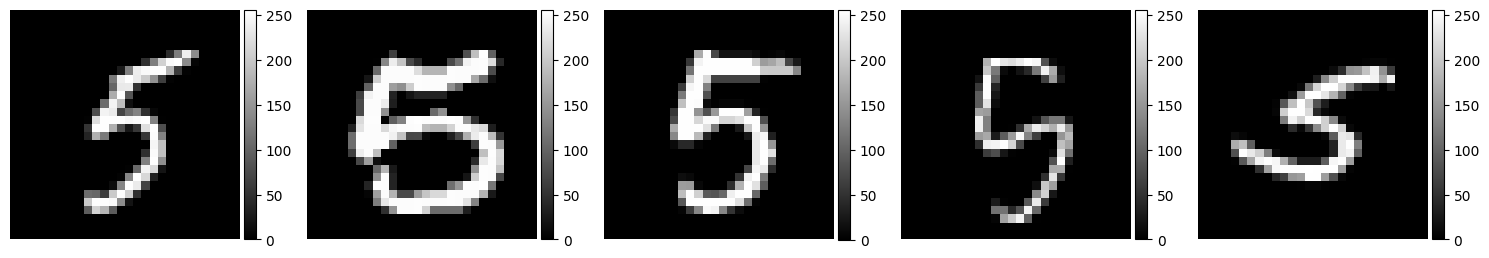

In [8]:
nb_vis = 5

# choose nb_vis sample indexes
idx = np.random.choice(x_train.shape[0], nb_vis, replace=False)
example_digits = [f for f in x_train[idx, ...]]

# plot
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

Looks good!  

However, luckily we included a **colorbar**, which shows us that the data is in [0, 255].  
In neural networks it's often great to work in the ranges of [0, 1] or [-1, 1] or around there.  
Let's fix this.

In general, you should always plot your data with colorbars, which helps you catch issues before training  

In [9]:
# fix data
x_train = x_train.astype('float')/255
x_val = x_val.astype('float')/255
x_test = x_test.astype('float')/255

# verify
print('training maximum value', x_train.max())

training maximum value 1.0


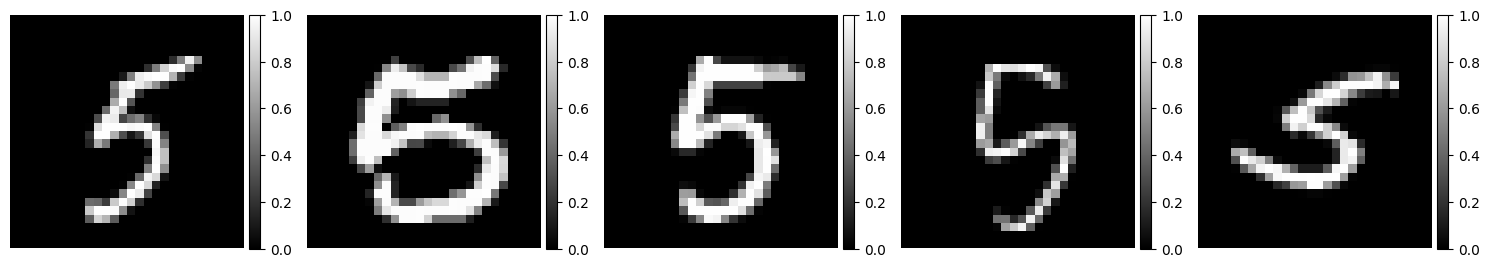

In [10]:
# re-visualize
example_digits = [f for f in x_train[idx, ...]]
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

One last change. Later on, we'll see that many popular models like to have inputs that are sized as multiples of 2^N for N being the number of layers. Here, we force our images to be size 32 (2x 2^4).

In [11]:
pad_amount = ((0, 0), (2,2), (2,2))

# fix data
x_train = np.pad(x_train, pad_amount, 'constant')
x_val = np.pad(x_val, pad_amount, 'constant')
x_test = np.pad(x_test, pad_amount, 'constant')

# verify
print('shape of training data', x_train.shape)

shape of training data (4421, 32, 32)


---

# Unsupervised image Registration (VoxelMorph)

To perform unsupervised registration with `voxelmorph`, we'll need two things: a CNN model (which takes as input two images and outputs what we care about, the deformation field), and a loss function that enable training.

## CNN Model

Given two images (which we call *moving* and *fixed*), our goal is to find the deformation between them. In learning-based methods, we use a network that takes in two images $m$ ("moving") and $f$ ("fixed") (e.g. MNIST digits of size 32x32) and outputs a dense deformation $\phi$ (e.g. size 32x32x2, because at each pixel we want a vector telling us where to go). Intuitively, this deformation $\phi$ gives us the correspondances between the images, and tells us how to moving the moving image to match up with the fixed image.

**Note**: Registration also includes (or refers to) affine transforms, but we ignore that in this tutorial.

The [VoxelMorph](http://voxelmorph.mit.edu) library provides a `VxmDense` model class for building dense deformation networks. We will discuss this class later on, but for tutorial sake, we'll start by building this model from scratch in order to demonstrate the individual components of the network. First, we're going to abstract a UNet architecture with the `vxm.networks.Unet()` model.

In [12]:
# configure unet input shape (concatenation of moving and fixed images)
ndim = 2
unet_input_features = 2
inshape = (*x_train.shape[1:], unet_input_features)

# configure unet features
nb_features = [
    [32, 32, 32, 32],         # encoder arm features
    [32, 32, 32, 32, 32, 16]  # decoder arm features
]

# build model
unet = vxm.networks.Unet(inshape=inshape, nb_features=nb_features)

Let's explore the model bit...

In [13]:
print('input shape: ', unet.input.shape)
print('output shape:', unet.output.shape)

input shape:  (None, 32, 32, 2)
output shape: (None, 32, 32, 16)


Now we need to make sure the final output has 2 features, representing the deformation at each voxel.

In [14]:
# transform the results into a flow field.
disp_tensor = tf.keras.layers.Conv2D(ndim, kernel_size=3, padding='same', name='disp')(unet.output)

# check tensor shape
print('displacement tensor:', disp_tensor.shape)

# using keras, we can easily form new models via tensor pointers
def_model = tf.keras.models.Model(unet.inputs, disp_tensor)

displacement tensor: (None, 32, 32, 2)


The deformation model `def_model` will now *share layers* with the UNet model, so if we change layer weights in `UNet`, they change in `def_model`.

## Loss

Given that the displacement $\phi$ is output from the network,  
we need to figure out a loss to tell if it makes sense

In a **supervised setting** we would have ground truth deformations $\phi_{gt}$,  
and we could use a supervised loss like MSE $= \| \phi - \phi_{gt} \|$

The main idea in **unsupervised registration** is to use a loss inspired by classical registration  

Without supervision, how do we know this deformation is good?  
(1) make sure that $m \circ \phi$ ($m$ warped by $\phi$) is close to $f$ for some notion of *similarity*    
(2) regularize $\phi$ (often meaning make sure it's smooth)  

To achieve (1), we need to *warp* input image $m$. To do this, we use a spatial transformation network layer, which essentially does linear interpolation.

In [15]:
# build transformer layer
spatial_transformer = vxm.layers.SpatialTransformer(name='transformer')

# extract the first frame (i.e. the "moving" image) from unet input tensor
moving_image = unet.input[..., 0, tf.newaxis]

# warp the moving image with the transformer
moved_image_tensor = spatial_transformer([moving_image, disp_tensor])

To make sure the moved image is close to the fixed image, and to achieve smoothness loss of $\phi$ in (2), we could put these tensors into a loss. However, it's often convenient to make these two tensors as outputs from the full model, as then we could further use the model and obtain both the moved image and the deformation field during testing in one shot.

In [16]:
outputs = [moved_image_tensor, disp_tensor]
vxm_model = tf.keras.models.Model(inputs=unet.inputs, outputs=outputs)

The model we just created represents the standard, dense VoxelMorph archetecture, with a UNet component, displacement field, and final spatial transformer layer. However, you don't have to build this model from scratch every time - the VoxelMorph library provides a highly customizable `VxmDense` model class that encompasses this archetecture.

From now on in the tutorial, we will be using `VxmDense` class to build models, so let's rebuild the equivolent network.

In [17]:
# build model using VxmDense
inshape = x_train.shape[1:]
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

The `int_steps=0` option disables diffeomorphism, which will be covered in a more advanced step of the tutorial.

The `VxmDense` model is automatically configured with two input tensors (moving and fixed inputs) instead of one. The input shape parameter should not contain any feature information, which can be set via the optional `src_feats` and `trg_feats` parameters.

Let's take one final look at the model.

In [18]:
print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 32, 32, 1), (None, 32, 32, 1)
output shape: (None, 32, 32, 1), (None, 32, 32, 2)


Now that we've learned how to easily build our networks, let's define the actual loss. The way keras works, we need to define a loss term for each output -- which matches the two losses in unsupervised registration: image matching and regularization.  

The first loss is easy, it's a similarity like MSE between the warped image $m \circ \phi$. The `voxelmorph` library has a variety of custom loss classes.

For the second, we will use a spatial gradient of the displacement.  
We won't code this from scratch here, but we'll use the `voxelmorph` implementation.

We also have to balance the loss terms with a hyperparameter. We'll have more insight on this in the advanced section via a method called [HyperMorph](https://arxiv.org/abs/2101.01035).

In [19]:
# loss terms
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

Finally, we can compile the model.
This sets up the model for training, by associating the model with a loss and an optimizer

In [20]:
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

## Train Model

To train, we need to make sure the data is in the right format and fed to the model the way we want it.  

keras models can be trained with `model.fit`, which works if all data is in a big array or through a python generator that gives you batches of data.

Let's code a simple data generator based on the MNIST data, which will convey the core ideas of how the data is fed at every iteration.

In [21]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    nb_items = x_data.shape[0]
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, nb_items, size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, nb_items, size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]

        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare
        # the resulting moved image with the fixed image, so we return
        # the fixed image.
        # Bescause keras requires a 'true' item for each output, we
        # return a volume of zeros -- this won't be used in the end.
        outputs = [fixed_images, zero_phi]

        yield (inputs, outputs)

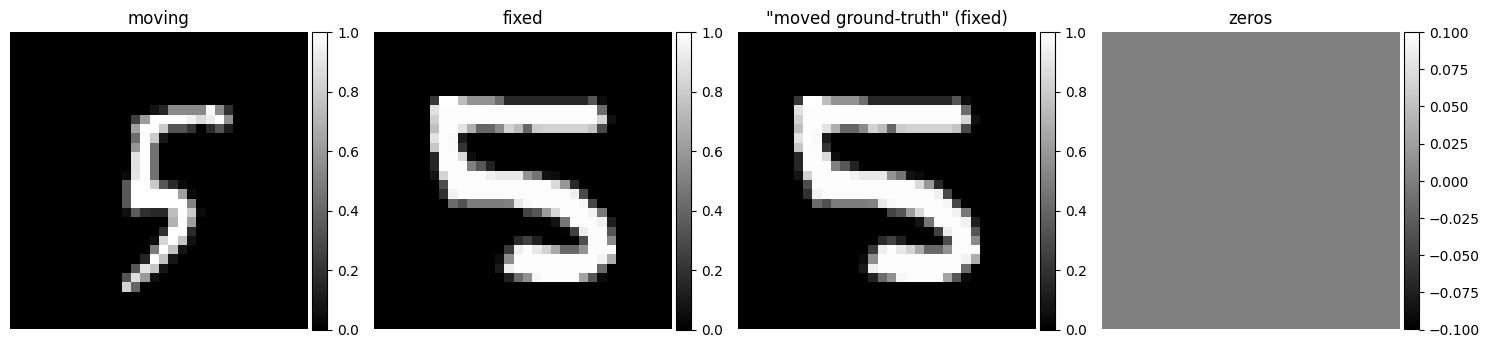

In [22]:
# let's test it
train_generator = vxm_data_generator(x_train)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', '"moved ground-truth" (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

Finally, we're going to train the model. In this tutorial the training speed will depend on the CPU/GPU/TPU you get from google, so we'll just train a few iterations for a few steps each.

Normally, we would train to convergence -- that is, unless the registration loss doesn't improve in a number of iterations.

In [23]:
# finally, let's train a model
nb_epochs = 10
steps_per_epoch = 100
hist = vxm_model.fit(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);

Epoch 1/10

100/100 - 7s - loss: 0.0525 - vxm_dense_transformer_loss: 0.0494 - vxm_dense_flow_loss: 0.0636 - 7s/epoch - 65ms/step
Epoch 2/10
100/100 - 3s - loss: 0.0243 - vxm_dense_transformer_loss: 0.0188 - vxm_dense_flow_loss: 0.1095 - 3s/epoch - 33ms/step
Epoch 3/10
100/100 - 4s - loss: 0.0186 - vxm_dense_transformer_loss: 0.0136 - vxm_dense_flow_loss: 0.1005 - 4s/epoch - 39ms/step
Epoch 4/10
100/100 - 3s - loss: 0.0163 - vxm_dense_transformer_loss: 0.0114 - vxm_dense_flow_loss: 0.0965 - 3s/epoch - 30ms/step
Epoch 5/10
100/100 - 4s - loss: 0.0151 - vxm_dense_transformer_loss: 0.0103 - vxm_dense_flow_loss: 0.0959 - 4s/epoch - 36ms/step
Epoch 6/10
100/100 - 3s - loss: 0.0141 - vxm_dense_transformer_loss: 0.0094 - vxm_dense_flow_loss: 0.0933 - 3s/epoch - 31ms/step
Epoch 7/10
100/100 - 3s - loss: 0.0134 - vxm_dense_transformer_loss: 0.0087 - vxm_dense_flow_loss: 0.0928 - 3s/epoch - 35ms/step
Epoch 8/10
100/100 - 4s - loss: 0.0127 - vxm_dense_transformer_loss: 0.0082 - vxm_dense_flow_los

It's always a good idea to visualize the loss, not just read off the numbers. This will give us a better idea of whether it's converged, etc. Tensorflow offers a powerful interactive system for visualizing called tensorboard. For this short tutorial, we will simply plot the loss.

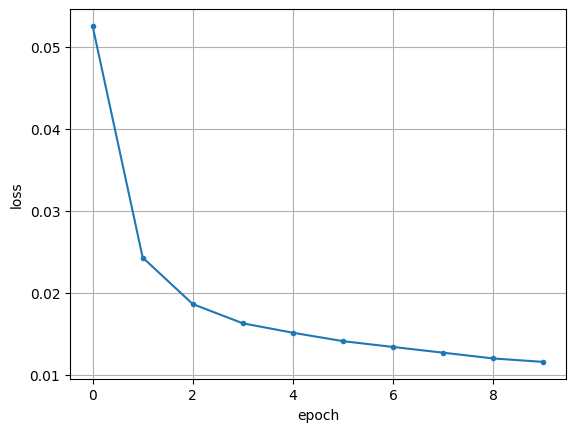

In [24]:
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.grid()
    plt.show()

plot_history(hist)

Clearly, this is not converged, and you should run it to convergence, but for the purposes of this tutorial, we'll move on.

**Detour**: always zoom in your loss to the last few iterations/epochs -- looking at the entire graph can be deceiving, since the starting point makes the final epochs appear flat, but often they are not.

## Registration

With pair-wise optimization methods (like most classical methods), to register a new pair you would need to optimize a deformation field.  

With learning based registration, we simply evaluate the network for a new input pair  

In [25]:
# let's get some data
val_generator = vxm_data_generator(x_val, batch_size=1)
val_input, _ = next(val_generator)

*Registration*: `predict()` essentially executes the network given an input.

In [26]:
val_pred = vxm_model.predict(val_input)

1/1 [==============================] - 0s 333ms/step


and that's it!

Even though this is on MNIST only, let's see how long this takes

In [27]:
# %timeit is a 'jupyter magic' that times the given line over several runs
%timeit vxm_model.predict(val_input)

1/1 [==============================] - 0s 19ms/step
68.4 ms ± 3.76 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


This is quite fast, even for MNIST. Let's visualize the results.

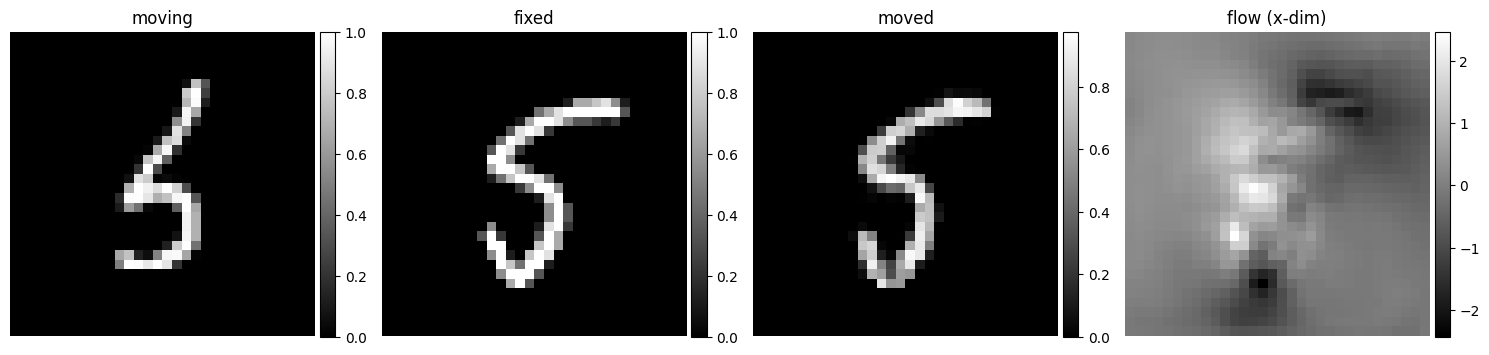

In [28]:
# visualize
images = [img[0, :, :, 0] for img in val_input + val_pred]
titles = ['moving', 'fixed', 'moved', 'flow (x-dim)']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

Let's visualize the flow a bit better, we'll draw little arrows.



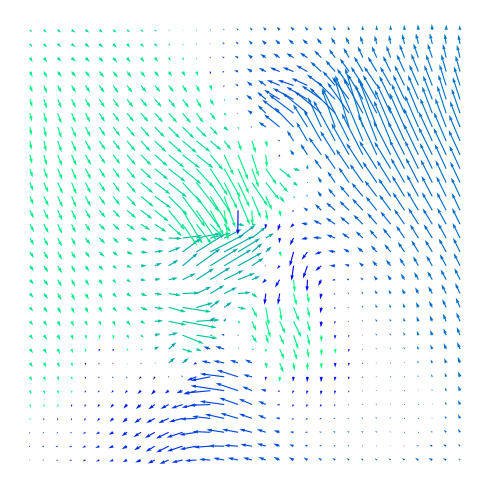

In [29]:
# flow is a plotting functionality in `neurite`
ne.plot.flow([val_pred[1].squeeze()], width=5);

## Generalization
How do learning-based methods generalize beyond training distribution ?

An important caveat to learning-based registration is that they will, in general, only register samples from the distribution they've been trained from.

So, what happens if we register two 7's?

In [30]:
# extract only instances of the digit 7
x_sevens = x_train_load[y_train_load==7, ...].astype('float') / 255
x_sevens = np.pad(x_sevens, pad_amount, 'constant')

# predict
seven_generator = vxm_data_generator(x_sevens, batch_size=1)
seven_sample, _ = next(seven_generator)
seven_pred = vxm_model.predict(seven_sample)

1/1 [==============================] - 0s 26ms/step


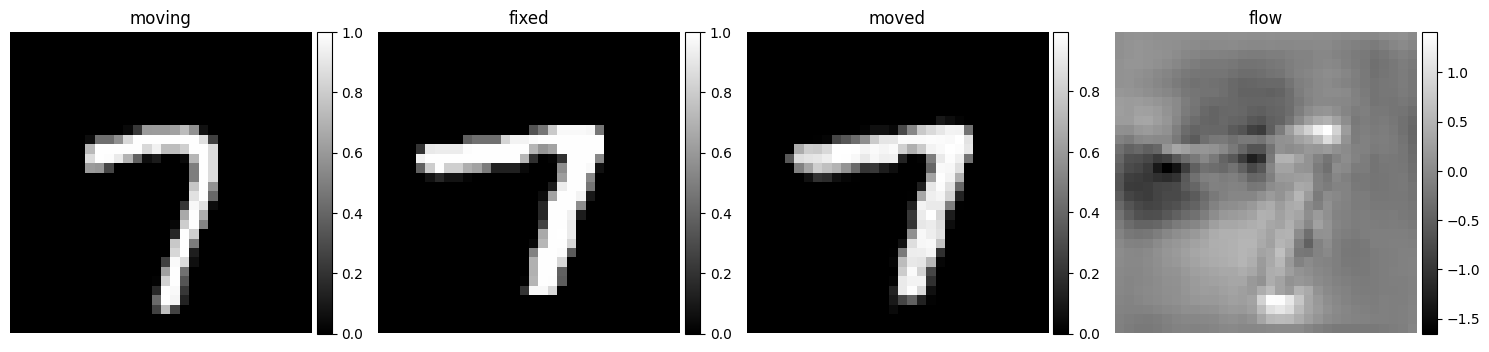

In [31]:
# visualize
images = [img[0, :, :, 0] for img in seven_sample + seven_pred]
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

Interesting - it still works! So it **generalized beyond what we expected**. Why?  

Locally, parts of the 7s look similar to the 5s, so the  registration algorithm still tries to match local neighborhoods.

Let's try a different variation. What if we just modify the (original) set, but multiplied the intensities by a factor?

1/1 [==============================] - 0s 26ms/step


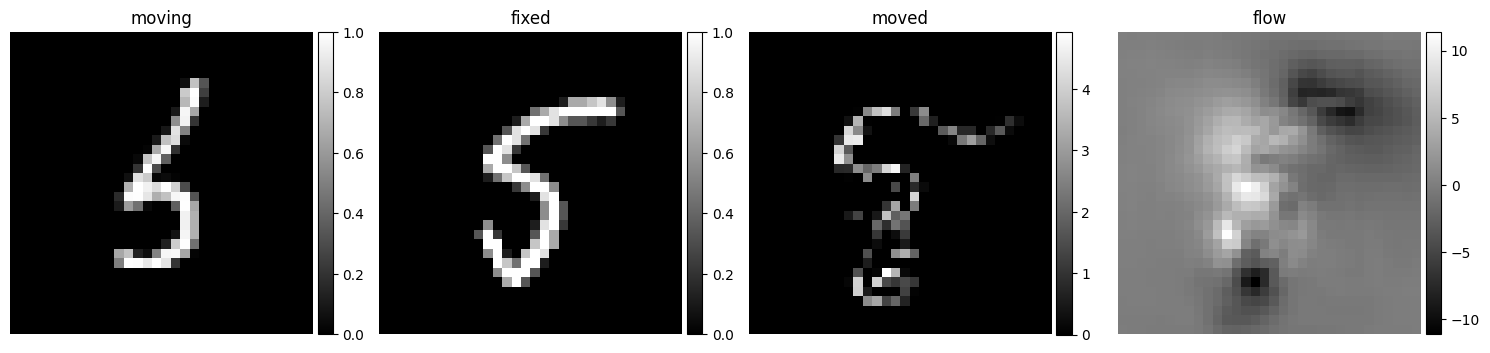

In [32]:
factor = 5
val_pred = vxm_model.predict([f * factor for f in val_input])

# visualizeb
images = [img[0, :, :, 0] for img in val_input + val_pred]
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

This broke down! Why? In this case, the network has never seen even parts of this image (because the intensities were so large). In that case, we don't know what the network will do -- it might work, it might not.

Understanding when the network generalizes and when it does not is very important, and still a part of active research.

# Unsupervised Registration of Brain MRI

We will now register slightly more realistic data - MRIs of the brain.  

To be able to train and easily register during this tutorial, we will first extract the middle slice of brain scans. Because this task does not capture deformations in the third dimensions, certain correspondances are not exactly possible.  Nonetheless, this exercise will illustrate registration with more realistic complex images.   

The brain scans have been intensity-normalized, affinely aligned, and skull-stripped with FreeSurfer, to enable focusing on deformable registration. These steps may not be strictly necessary, but help in the tutorial.

## Data: Brain Scans

In [33]:
# download MRI tutorial data
!wget https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz -O data.tar.gz
!tar -xzvf data.tar.gz

'wget' is not recognized as an internal or external command,
operable program or batch file.
tar: Error opening archive: Failed to open 'data.tar.gz'


In [36]:
# we're going to load some data that we packaged for this tutorial
npz = ne.py.data.load_dataset('2D-OASIS-TUTORIAL')
x_train = npz[2]
x_val = npz[7]

# the 208 volumes are of size 192 x 160
print('train shape:', x_train.shape)
vol_shape = x_train.shape[1:]

train shape: (160, 160, 1)


### Data Visualization
Let's take a look at some of the data.

In [37]:
# extract some brains
nb_vis = 5
idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

AssertionError: each slice has to be 2d or RGB (3 channels)

## Model

As with MNIST, let's create a standard VoxelMorph model trained with MSE and spatial smoothing losses.

In [ ]:
# unet
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)

# losses and loss weights
losses = ['mse', vxm.losses.Grad('l2').loss]
loss_weights = [1, 0.01]

From experimentation, we have found the Adam optimizer learning rate of `1e-4` performs better than `1e-3` for this problem and for small batch sizes.

In [ ]:
vxm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=losses, loss_weights=loss_weights)

Luckily, we can use the same **data generator** as before, since the only thing that's changes is the stack of data, which we pass to the generator.

Let's test it first.

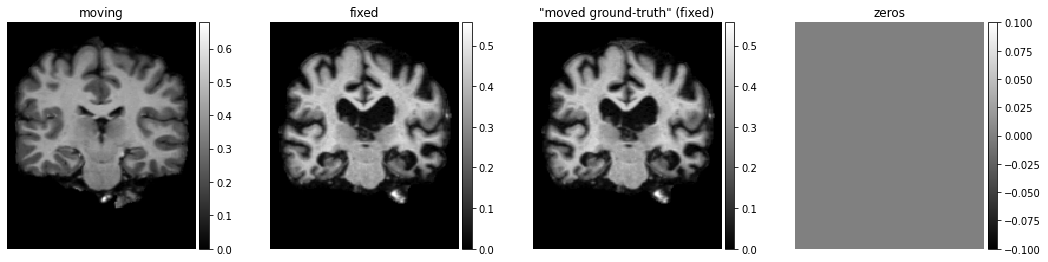

In [ ]:
# get new generator
train_generator = vxm_data_generator(x_train, batch_size=8)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', '"moved ground-truth" (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

Looks good, time to **train the model**  
As before, we'll only train for a bit for illustration purposes. You should train to completion!

In [ ]:
nb_epochs = 5
steps_per_epoch = 20
hist = vxm_model.fit(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);

Epoch 1/5
20/20 - 4s - loss: 0.0069 - transformer_loss: 0.0069 - flow_loss: 7.6848e-06
Epoch 2/5
20/20 - 1s - loss: 0.0068 - transformer_loss: 0.0068 - flow_loss: 7.5279e-05
Epoch 3/5
20/20 - 1s - loss: 0.0069 - transformer_loss: 0.0069 - flow_loss: 6.7144e-05
Epoch 4/5
20/20 - 1s - loss: 0.0072 - transformer_loss: 0.0072 - flow_loss: 7.0025e-05
Epoch 5/5
20/20 - 1s - loss: 0.0067 - transformer_loss: 0.0067 - flow_loss: 9.8113e-05


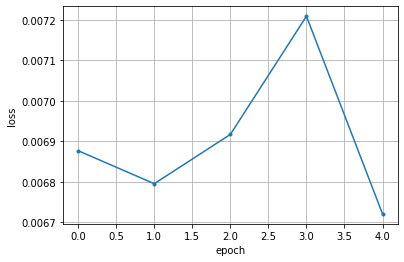

In [ ]:
# as before, let's visualize what happened
plot_history(hist)

We ran very few epochs for the purpose of the tutorial. Of course, we do not expect any sort of reasonable convergence here.

To be able to move on with the tutorial without waiting too long, let's load a model we've pretrained for 200 epochs:

In [ ]:
# load pretrained model weights
vxm_model.load_weights('brain_2d_smooth.h5')

Now let's see some results using validation data

In [ ]:
# create the validation data generator
val_generator = vxm_data_generator(x_val, batch_size=1)
val_input, _ = next(val_generator)

In [ ]:
# registration of this validation pair
val_pred = vxm_model.predict(val_input)

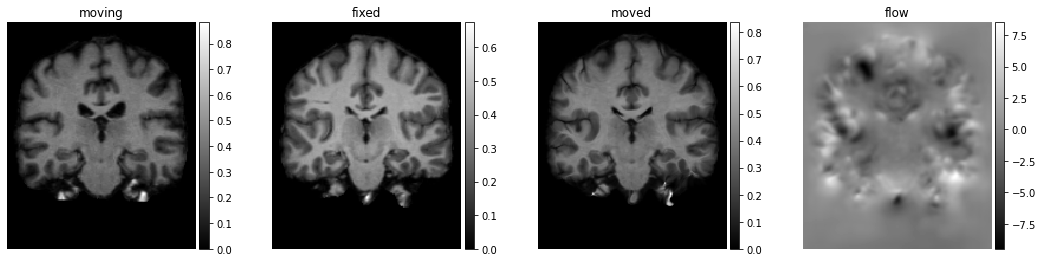

In [ ]:
# visualize registration
images = [img[0, :, :, 0] for img in val_input + val_pred]
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

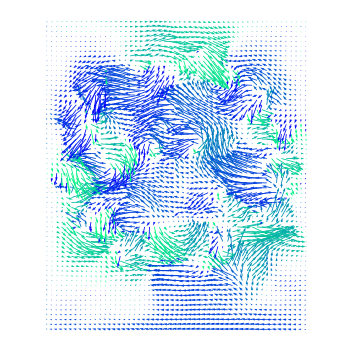

In [ ]:
# visualize the flow
flow = val_pred[1].squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

## Evaluation

Evaluating registration results is tricky. The first tendancy is to look at the images (as above), and conclude that if they match, the registration has succeeded.

However, image matching can be achieved by an optimization that only penalizes the image matching term, and does not care whether the deformation field is reasonable. For example, next we compare our model with one that was trained on maximizing MSE only (without smoothness loss).

In [ ]:
# prediction from model with MSE + smoothness loss
vxm_model.load_weights('brain_2d_smooth.h5')
our_val_pred = vxm_model.predict(val_input)

# prediction from model with just MSE loss
vxm_model.load_weights('brain_2d_no_smooth.h5')
mse_val_pred = vxm_model.predict(val_input)

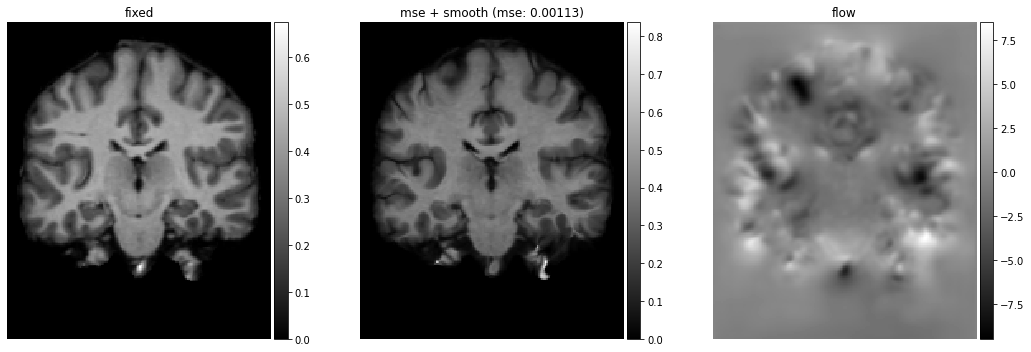

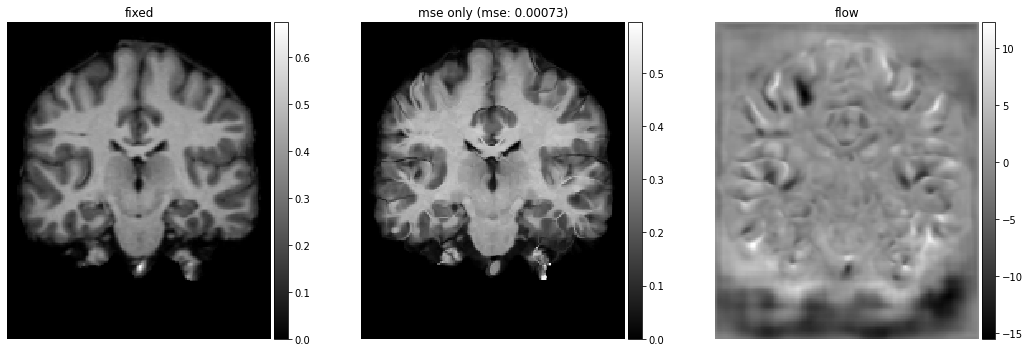

In [ ]:
def visualize_vxm_results(vols, title):
  images = [img[0, ..., 0] for img in vols]
  mse = tf.keras.metrics.mean_squared_error(images[0], images[1]).numpy().mean()
  titles = ['fixed', '%s (mse: %.5f)' % (title, mse), 'flow']
  ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

# visualize MSE + smoothness model output
visualize_vxm_results([val_input[1], *our_val_pred], 'mse + smooth')

# visualize MSE model output
visualize_vxm_results([val_input[1], *mse_val_pred], 'mse only')

The MSE is (usually) lower for the second network. So the images 'match up better' in terms of intensity alignment. But the fields to achieve this are much less reasonable:

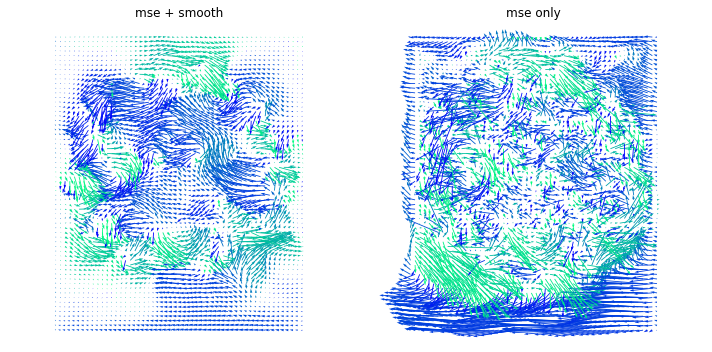

In [ ]:
flows = [img[1].squeeze()[::3, ::3] for img in [our_val_pred, mse_val_pred]]
titles = ['mse + smooth', 'mse only']
ne.plot.flow(flows, width=10, titles=titles);

What we often do to evaluate the registration is to use **external anotations**. One variant is using anatomical segmentations.  

In the next section, we demonstrate the use of a 3D model, and show how to evaluate it with segmentations.

# 3D MRI brain scan registration

Finally we get to 3D models, which are of particular interest in medical image analysis.

However, due to the size of the models and data, we won't be able to train a model within a short tutorial time. Instead, here we assume one has been trained, and demonstrate its use. You can train one very similar to how you trained the 2D models above.

### Model

In [ ]:
# our data will be of shape 160 x 192 x 224
vol_shape = (160, 192, 224)
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]

In [ ]:
# build vxm network
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

Load a trained 3D model.

In [ ]:
vxm_model.load_weights('brain_3d.h5')

### Validation data

Let's prepare our validation data.

In [ ]:
val_volume_1 = np.load('subj1.npz')['vol']
seg_volume_1 = np.load('subj1.npz')['seg']
val_volume_2 = np.load('subj2.npz')['vol']
seg_volume_2 = np.load('subj2.npz')['seg']

val_input = [
    val_volume_1[np.newaxis, ..., np.newaxis],
    val_volume_2[np.newaxis, ..., np.newaxis]
]

## Registration
Now let's register two 3d validation volumes. The first time the model is run it will take a bit extra time due to some behind the scenes initializations.

In [ ]:
val_pred = vxm_model.predict(val_input);
moved_pred = val_pred[0].squeeze() # moved volume.
pred_warp = val_pred[1]            # warp

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


## Visualize Results
To visualize, we'll need to take out slices, since these are 3D volumes

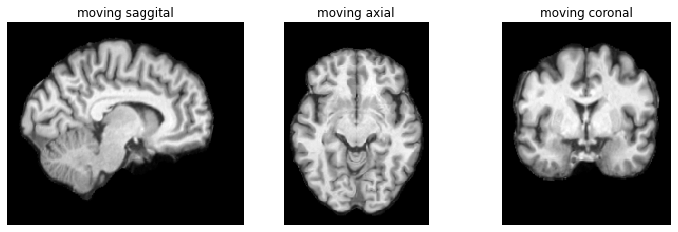

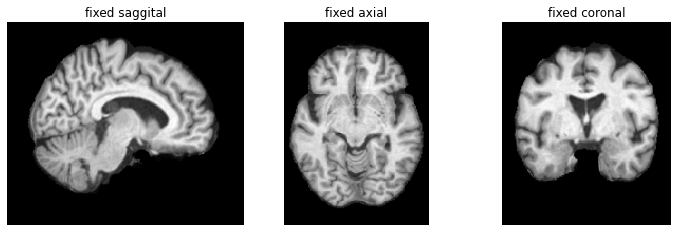

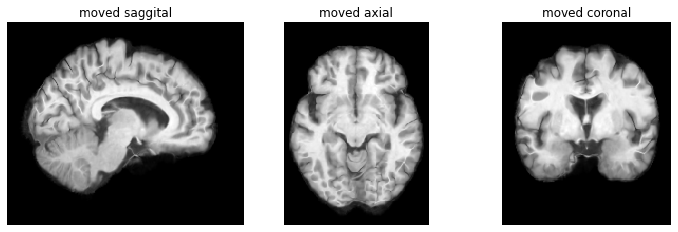

In [ ]:
# Some useful functions first
def extract_slices(vol):
  mid_slices = [np.take(vol, vol.shape[d]//1.8, axis=d) for d in range(3)]
  mid_slices[1] = np.rot90(mid_slices[1], 1)
  mid_slices[2] = np.rot90(mid_slices[2], -1)
  return mid_slices

titlefn = lambda x: ['%s %s' % (x, f) for f in ['saggital', 'axial', 'coronal']]

# show moving, fixed, and moved volumes
ne.plot.slices(extract_slices(val_volume_1), titles=titlefn('moving'), cmaps=['gray'], width=10)
ne.plot.slices(extract_slices(val_volume_2), titles=titlefn('fixed'), cmaps=['gray'], width=10)
ne.plot.slices(extract_slices(moved_pred), titles=titlefn('moved'), cmaps=['gray'], width=10);

Let's look at the segmentations! To do this, we'll need to warp segmentation maps.

We'll need to grab a model that does such warping first.

In [ ]:
# let's get a model that transforms images with nearest-enighbout interpolation.
# this model takes in a volume and a deformation fields, and outputs the deformed volume
warp_model = vxm.networks.Transform(vol_shape, interp_method='nearest')

In [ ]:
# let's warp the 'moving' segmentaiton map
warped_seg = warp_model.predict([seg_volume_1[np.newaxis,...,np.newaxis], pred_warp])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


To prepare out visualization, we're first going to prepare a colormap. We use the freesurfer colormap, which has been carefully chosen to clearly see distinct brain structures.

In [ ]:
import matplotlib

fs_colors = np.load('fs_rgb.npy')
ccmap = matplotlib.colors.ListedColormap(fs_colors)

Let's visualize the segmentation maps, and make sure they are sensible

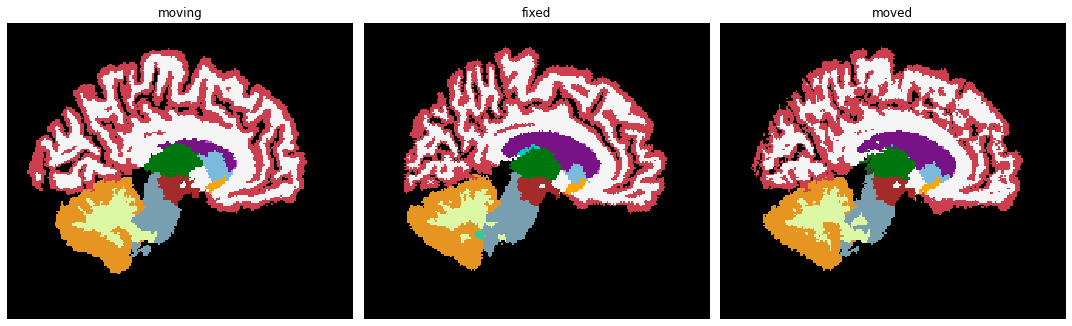

In [ ]:
mid_slices_moving = seg_volume_1.squeeze()[int(seg_volume_1.shape[0]//1.8), ...]
mid_slices_fixed = seg_volume_2.squeeze()[int(seg_volume_1.shape[0]//1.8), ...]
mid_slices_moved = warped_seg.squeeze()[int(seg_volume_1.shape[0]//1.8), ...]

slices = [mid_slices_moving, mid_slices_fixed, mid_slices_moved]

titles = ['moving', 'fixed', 'moved']
# the imshow arguments here are simply to maintain freesurfer colors
ne.plot.slices(slices, cmaps=[ccmap], imshow_args=[{'vmin':0, 'vmax':255}], titles=titles);

We're only visualizing a saggital slice here, for ease of visualization. We can see that the anatomical regions match up substantially better after registration (i.e. between moved and fixed).

## Runtime

An important advantage of learning-based methods is the dramatically lowered runtime.

In [ ]:
%timeit vxm_model.predict(val_input)

1 loop, best of 5: 900 ms per loop


In our tests, a run is 10s, for an entire 3D volume. Classically, this would take tens of minutes to hours on a CPU.

---------

# Bonus: Atlas Building Demo

We'll cover one advanced topic (if all of the above makes sense!) with a bit less focus on the details and more focus on the big picture of new models: atlas (template) building.

Atlases (templates) are powerful analysis entities that are often behind the current workhorse piplines in medical image analysis. There are very popular atlases that are available for download (like MNI brain atlas), but we often want to build a template that represents our data. Here, we'll walk through how to [build templates within VoxelMorph directly](https://arxiv.org/abs/1908.02738).

First, we'll have to do some book keeping again: some installations and data wrangling.

In [ ]:
!pip install tensorflow_addons  # for tqdm callbacks

     |████████████████████████████████| 679 kB 6.4 MB/s 


In [ ]:
# some imports we'll need throughout the demo
import os

# some third party very useful libraries
import tensorflow as tf
import tensorflow_addons as tfa  # for TQDM callback
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import nibabel as nib

# our libraries
import voxelmorph as vxm
import neurite as ne

## Utilities

In [ ]:
# turn off eager for this
# need to do it due to some tf 2.0+ compatibility issues
tf.compat.v1.disable_eager_execution()

In [ ]:
# some helpful functions
def plot_hist(hist):
  plt.figure(figsize=(17,5))
  plt.subplot(1, 2, 1)
  plt.plot(hist.epoch, hist.history['loss'], '.-')
  plt.ylabel('loss')
  plt.xlabel('epochs');
  plt.grid()

  plt.subplot(1, 2, 2)
  nb_epochs = len(hist.epoch) // 2
  plt.plot(hist.epoch[-nb_epochs:], hist.history['loss'][-nb_epochs:], '.-')
  plt.ylabel('loss')
  plt.xlabel('epochs');
  plt.grid()
  plt.show()

In [ ]:
# generally useful callback
# unfortunately show_epoch_progress=True leaves a printout that we can't control (bad implementation in tfa...)
tqdm_cb = tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False, show_epoch_progress=False)

### Data
We'll need MNIST again with slightly different processing

In [ ]:
# let's load up MNIST again
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
x_train_all = x_train_all.astype('float')/255
x_test_all = x_test_all.astype('float')/255

x_train_all = np.pad(x_train_all, ((0, 0), (2, 2), (2, 2)), 'constant')[..., np.newaxis]
x_test_all = np.pad(x_test_all, ((0, 0), (2, 2), (2, 2)), 'constant')[..., np.newaxis]

In [ ]:
# extract all 5s
digit = 5

x_train = x_train_all[y_train_all == digit, ...]
y_train = y_train_all[y_train_all == digit]
x_test = x_test_all[y_test_all == digit, ...].astype('float')/255
y_test = y_test_all[y_test_all == digit]

vol_shape = list(x_train.shape[1:-1])

In [ ]:
# prepare a simple generator to template generation
def template_gen(x, batch_size):
  vol_shape = list(x.shape[1:-1])
  zero = np.zeros([batch_size] + vol_shape + [2])
  mean_atlas = np.repeat(np.mean(x, 0, keepdims=True), batch_size, 0)

  while True:
    idx = np.random.randint(0, x.shape[0], batch_size)
    img = x[idx, ...]
    inputs = [mean_atlas, img]
    outputs = [img, zero, zero, zero]
    yield inputs, outputs

# let's make sure the sizes make sense
sample = next(template_gen(x_train, 8))
[f.shape for f in sample[0]], [f.shape for f in sample[1]]

([(8, 32, 32, 1), (8, 32, 32, 1)],
 [(8, 32, 32, 1), (8, 32, 32, 2), (8, 32, 32, 2), (8, 32, 32, 2)])

## Unconditional Template (MNIST)

We will build two types of templates: unconditional (one template per population) and conditional (i.e. a template as a function of attributes we care about, like diagnosis or age)

### Model

The template creation is essentially the same as a voxelmorph model, but instead of the moving image being a simple image, it's a set of parameters at each voxel that will be learned.

In [ ]:
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]
model = vxm.networks.TemplateCreation(vol_shape, nb_unet_features=[enc_nf, dec_nf])

LocalParamWithInput: Consider using neuron.layers.LocalParam()


Because the model is so similar to voxelmorph, the losses will be as well. THere are two loss terms:
 - one *inverse similarity*, which is the similarity of applying the inverse of the deformation field to the image, to move it to the atlas
 - one *centrality* that encourages the **average** of all deformation fields in the dataset to be zero, making the atlas *central*  

In [ ]:
# prepare losses and compile
image_loss_func = vxm.losses.MSE().loss
neg_loss_func = lambda _, y_pred: image_loss_func(model.references.atlas_tensor, y_pred)
losses = [image_loss_func, neg_loss_func, vxm.losses.MSE().loss, vxm.losses.Grad('l2', loss_mult=2).loss]
loss_weights = [0.5, 0.5, 1, 0.01]

model.compile('adam', loss=losses, loss_weights=loss_weights)

In [ ]:
# train model
gen = template_gen(x_train, batch_size=8)
hist = model.fit(gen, epochs=100, steps_per_epoch=25, verbose=0, callbacks=[tqdm_cb])

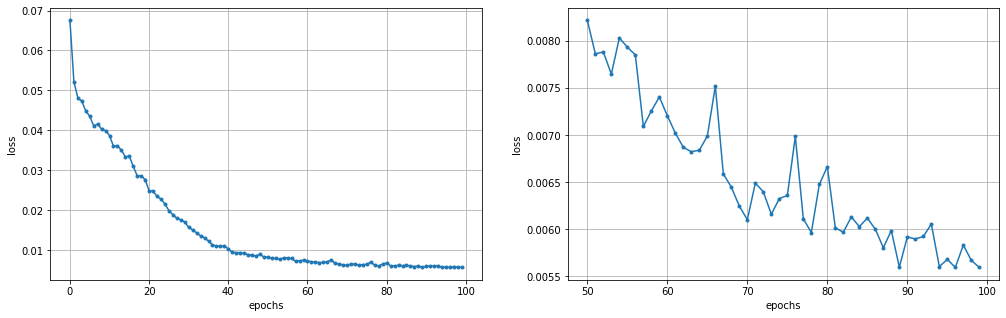

In [ ]:
# visualize training curve
plot_hist(hist)

Okay, this seems somewhat converged. For now, we will focus on analyzing what the atlas looks like after this training. But remember, this is a full voxelmorph model as well -- meaning it can register the images (in this case, 5s) to the atlas!

### Visualize Results

Text(0.5, 1.0, 'atlas')

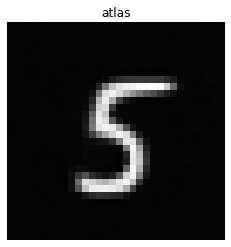

In [ ]:
# visualize learned atlas
atlas = model.references.atlas_layer.get_weights()[0][..., 0]
plt.imshow(atlas, cmap='gray')
plt.axis('off');
plt.title('atlas')

Looks like an average but sharp 5! Substantially sharper than average all 5s, or any other simplistic method.

Okay, so what does this buy us? This enables learning central templates (atlases) very quickly, which we often need for analyses.

But it also enables easy extensions that can be very powerful, like conditional templates, which we cover below

## Unconditional Template (2D Brain slices)

Let's try the same thing with brains (in this case, we'll keep to 2D mid-coronal slices, to make the tutorial work)

### Get Brain Data
This is data we released as part of neurite, please read more about it [here](https://github.com/adalca/medical-datasets/blob/master/neurite-oasis.md).

In [ ]:
# get the data
!wget wget http://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar -O data.tar
!tar -xf data.tar;

--2021-08-03 02:27:46--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2021-08-03 02:27:46--  http://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.240.105
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.240.105|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar [following]
--2021-08-03 02:27:46--  https://surfer.nmr.mgh.harvard.edu/ftp/data/neurite/data/neurite-oasis.2d.v1.0.tar
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.240.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24903680 (24M) [application/x-tar]
Saving to: ‘data.tar’

data.tar            100%[===================>]  23.75M  18.5MB/s    in 1.3s    



In [ ]:
# prepare data
files = [f + '/slice_norm.nii.gz' for f in os.listdir('.') if f.startswith('OASIS_OAS1_')]
vols = [nib.load(f).get_fdata() for f in tqdm(files)]
x_vols = np.stack(vols, 0)
vol_shape = x_vols.shape[1:-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


### Model

In [ ]:
# get the model
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]
model = vxm.networks.TemplateCreation(vol_shape, nb_unet_features=[enc_nf, dec_nf])

LocalParamWithInput: Consider using neuron.layers.LocalParam()


In [ ]:
# prepare losses
image_loss_func = vxm.losses.MSE().loss
neg_loss_func = lambda _, y_pred: image_loss_func(model.references.atlas_tensor, y_pred)
losses = [image_loss_func, neg_loss_func, vxm.losses.MSE().loss, vxm.losses.Grad('l2', loss_mult=2).loss]
loss_weights = [0.5, 0.5, 1, 0.01]

model.compile('adam', loss=losses, loss_weights=loss_weights)

In [ ]:
# train
gen = template_gen(x_vols, batch_size=2)
hist = model.fit(gen, epochs=100, steps_per_epoch=25, verbose=0, callbacks=[tqdm_cb])

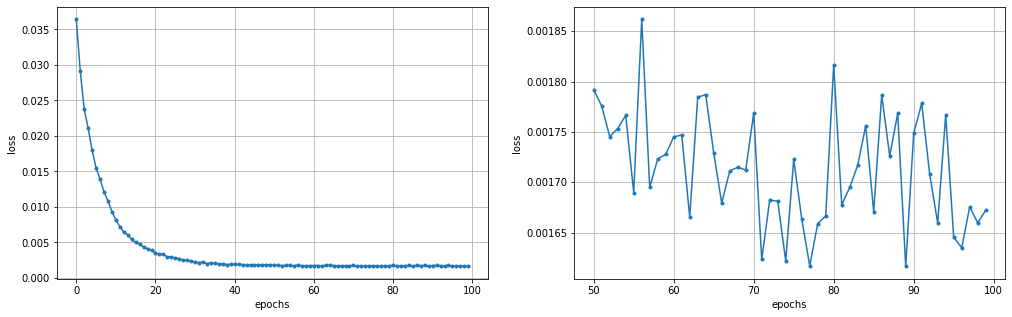

In [ ]:
# visualize optimization
plot_hist(hist)

### Visualize Atlas

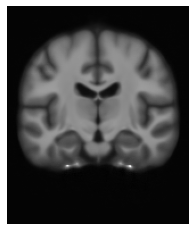

In [ ]:
atlas = model.references.atlas_layer.get_weights()[0][..., 0]
plt.imshow(np.rot90(atlas, -1), cmap='gray')
plt.axis('off');

This simple template code was able to capture important structures in the brain while still being central and representing the 'average brain'. There are a varity of ways to analyze this brain -- how central it is, how sharp it is, how well other scans can register to it, how good/bad those registrations are (which you can get with the same trained model!), etc. These are beyond the scope of this tutorial, but interesting and active research directions.

## Conditional Template (MNIST)

Finally, we describe how to build *conditional* templates -- template that are not just one image, but a *function* of attributes we care about. In medical imaging, important attributes we often care about are age or genetic makeup.

For this tutorial, we will work with MNIST as an example

## Data (all MNIST)

In [ ]:
# back to MNIST, all digits this time
x_train = x_train_all
y_train = y_train_all
y_train_onehot = tf.keras.utils.to_categorical(y_train_all, 10)
x_test = x_test_all
y_test = y_train_all
vol_shape = list(x_train.shape[1:-1])

In [ ]:
# prepare a simple generator.
def cond_template_gen(x, y, batch_size):
  vol_shape = list(x.shape[1:-1])
  zero = np.zeros([batch_size] + vol_shape + [2])
  atlas = np.repeat(np.mean(x, 0, keepdims=True), batch_size, 0)

  while True:
    idx = np.random.randint(0, x.shape[0], batch_size)
    img = x[idx, ...]
    inputs = [y[idx, ...], atlas, img]

    outputs = [img, zero, zero, zero]
    yield inputs, outputs

sample = next(cond_template_gen(x_train, y_train_onehot, 8))
[f.shape for f in sample[0]], [f.shape for f in sample[1]]

([(8, 10), (8, 32, 32, 1), (8, 32, 32, 1)],
 [(8, 32, 32, 1), (8, 32, 32, 2), (8, 32, 32, 2), (8, 32, 32, 2)])

### Model

The model is a simple extension to the previous template model -- but instead of learning one template, there's a small decoder architecture -- which takes in teh attribute, and outputs the template. This in turn gets fed as the 'moving' image to a voxelmorph architecture, and it's all trained end to end. During training, we feed in one attribute and one image -- so for example, we feed in (5, X) where X is a MNIST image of the digit 5.  

In [ ]:
enc_nf = [16,32,32,32]
dec_nf = [32,32,32,32,16,16,3]
model = vxm.networks.ConditionalTemplateCreation(vol_shape,
                                                 pheno_input_shape=[10], # 10 digits
                                                 nb_unet_features=[enc_nf, dec_nf],
                                                 conv_nb_features=16,
                                                 conv_image_shape=[4, 4, 8],
                                                 conv_nb_levels=4)
# model.summary()

Instructions for updating:
Use fn_output_signature instead


The losses are basically the same as before! Which is great, fewer changes are better!

In [ ]:
# prepare losses
image_loss_func = vxm.losses.MSE().loss
losses = [image_loss_func, vxm.losses.MSE().loss, vxm.losses.Grad('l2', loss_mult=2).loss, vxm.losses.MSE().loss]
loss_weights = [1, 0.01, 0.03, 0]  # changed second-last to 0.01

model.compile('adam', loss=losses, loss_weights=loss_weights)

In [ ]:
# fit the model. This one might take a bit longer as it's a bit more involved -
# but feel free to change the epochs or steps to be smaller.
# It will give less converged results, but likely still illustrate the ideas.
gen = cond_template_gen(x_train, y_train_onehot, batch_size=32)
hist = model.fit(gen, epochs=100, steps_per_epoch=10, verbose=0, callbacks=[tqdm_cb])

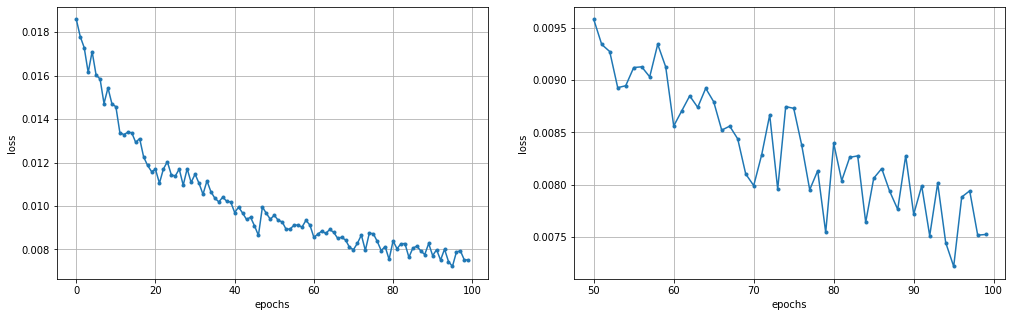

In [ ]:
plot_hist(hist)

## Visualize atlas

Finally, let's visualize the result. Since this is a conditional atlas, we will extract the decoder (atlas) model, which takes in attributes and outputs the appropriate atlas.

In [ ]:
atlas_model = tf.keras.models.Model(model.inputs[:2], model.get_layer('atlas').output)

Prepare the input data (basically a list of the digits we want to see).

In [ ]:
mean_atlas = np.repeat(np.mean(x_train, 0, keepdims=True), 10, 0)
input_samples = [tf.keras.utils.to_categorical(np.arange(10), 10), mean_atlas]

Get the atlases by running the model

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


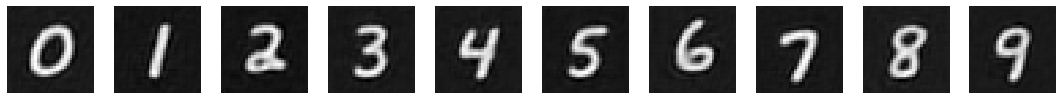

In [ ]:
pred = atlas_model.predict(input_samples)
ne.plot.slices([f.squeeze() for f in pred], cmaps=['gray']);

Neat! We can see templates learned as a condition of the input attribute (the digit) purely from the data. Of course, these are not converged yet, so they will get sharper as the model is trained more.

More examples can be found [here](http://voxelmorph.mit.edu/atlas_creation/) -- be sure to go use this on your own data, and hopefully this tutorial has enabled you to build your own models!

# References
[VoxelMorph at TMI](https://arxiv.org/abs/1809.05231)   
[Diffeomorphic VoxelMorph at MedIA](https://arxiv.org/abs/1903.03545)   
[Neurite Library](https://github.com/adalca/neuron) - [CVPR](http://arxiv.org/abs/1903.03148)  
[Template Building - NeurIPS](https://arxiv.org/abs/1908.02738)